# Aspect ratio wing deflection surrogate

This file contains the procedures on obtaining a surrogate

First read the data inputs

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
cwd = os.getcwd()
os.chdir(cwd+'/aspectRatio_wingDef/')
data_pandas = pd.read_csv('ar_wing_def.csv') 

In [3]:
data_pandas.head()

,Unnamed: 0,AR,wing_Def,semi_span
0,0,10,0.005397,1.24123
1,1,20,0.388028,6.24123
2,2,30,2.442584,11.24123
3,3,40,6.821455,16.24123


Extract the data inputs from the pandas DataFrame

In [4]:
data_numpy = data_pandas.to_numpy()

In [5]:
print(data_numpy)

[[0.00000000e+00 1.00000000e+01 5.39659216e-03 1.24122952e+00]
 [1.00000000e+00 2.00000000e+01 3.88028118e-01 6.24122952e+00]
 [2.00000000e+00 3.00000000e+01 2.44258402e+00 1.12412295e+01]
 [3.00000000e+00 4.00000000e+01 6.82145531e+00 1.62412295e+01]]


Transfer columns to individual numpy variables

In [6]:
AR = data_numpy[:,1]
wing_def = data_numpy[:,2]
semi_span = data_numpy[:,3]

In [7]:
print(AR)
print(wing_def)
print(semi_span)

[10. 20. 30. 40.]
[5.39659216e-03 3.88028118e-01 2.44258402e+00 6.82145531e+00]
[ 1.24122952  6.24122952 11.24122952 16.24122952]


Do a non-dimensionalisation wrt. wing semi_span. Could look in literature how other people have done it

In [8]:
wingDef_nonDim = wing_def/semi_span
print(wingDef_nonDim)

[0.00434778 0.06217174 0.21728798 0.42000855]


## Plot results

Text(0.5, 0, 'AR')

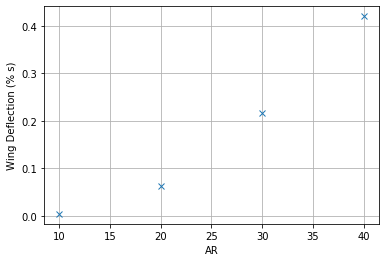

In [9]:
fig = plt.figure()
ax  = fig.add_subplot(1,1,1)
plt.plot(AR,wingDef_nonDim,'x')
ax.grid(True)
ax.set_ylabel('Wing Deflection (% s)')
ax.set_xlabel('AR')

## Curve Fitting

First approach is to use a polynomial, can try various degrees e.g 2nd order, 3rd order etc... Note that 4th order should give zero error at the training data points


In [10]:
def polynomial_basis(k,x):
    """Evaluates vector x using a kth degree polynomial.

    Args:
        k      (int): Degree of polynomial to be used
        x (np.array): Vector of points to be evaluated

    Returns:
        b (np.array): 2D array with evaluations of x for 

    """
    num = x.size
    b = np.zeros([num,k+1])
    b[:,0] = 1
    for i in range(num):
        for j in range(k):
            b[i,j+1] = x[i]**(j+1)
    return b
        
    

Test the function 

In [11]:
k = 2
x = AR
b = polynomial_basis(k,x)
print(b)

[[1.0e+00 1.0e+01 1.0e+02]
 [1.0e+00 2.0e+01 4.0e+02]
 [1.0e+00 3.0e+01 9.0e+02]
 [1.0e+00 4.0e+01 1.6e+03]]


In [12]:
test = np.zeros([len(x),k+1])
test[:,0] = 1

for i in range(len(x)):
    for j in range(k):
        test[i,j+1] = AR[i]
print(test)

[[ 1. 10. 10.]
 [ 1. 20. 20.]
 [ 1. 30. 30.]
 [ 1. 40. 40.]]


Now implement the regression model. Try using the method from Kochenderfer which utilises the Pseudoinverse from numpy : numpy.linalg.pinv

In [13]:
bpinv = np.linalg.pinv(b)

print(bpinv)

print(wingDef_nonDim)
print('\n')
# Use matrix arithmetic
wingDef_nonDim = np.matrix(wingDef_nonDim).T # Makes it a column vector
bpinv = np.matrix(bpinv)

print(bpinv)
print(wingDef_nonDim)
print('\n')
params = bpinv*wingDef_nonDim
print(params)

[[ 2.25   -0.75   -1.25    0.75  ]
 [-0.155   0.115   0.135  -0.095 ]
 [ 0.0025 -0.0025 -0.0025  0.0025]]
[0.00434778 0.06217174 0.21728798 0.42000855]


[[ 2.25   -0.75   -1.25    0.75  ]
 [-0.155   0.115   0.135  -0.095 ]
 [ 0.0025 -0.0025 -0.0025  0.0025]]
[[0.00434778]
 [0.06217174]
 [0.21728798]
 [0.42000855]]


[[ 0.00655014]
 [-0.00409109]
 [ 0.00036224]]


Evaluate the surrogate at many x points


In [14]:
xp = np.linspace(AR[0],AR[len(AR)-1],100)
yp = np.zeros([len(xp),])
for i in range(len(yp)):
    btest = polynomial_basis(k,np.array([xp[i]]))
    yp[i] = np.dot(btest,params)




Plot results to see if the graphs roughly match

In [15]:
xp.shape
yp.shape

(100,)

Text(0.5, 0, 'AR')

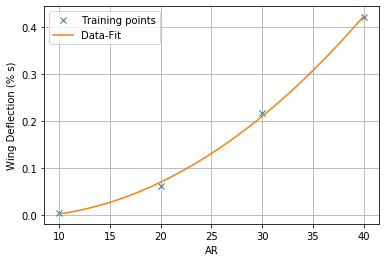

In [16]:
fig2, ax = plt.subplots()

ax.plot(AR,wingDef_nonDim,'x')
ax.plot(xp,yp)

ax.legend(["Training points","Data-Fit"])
ax.grid(True)
ax.set_ylabel('Wing Deflection (% s)')
ax.set_xlabel('AR')




## Get the errors from testing data

In [17]:
# Read the data
test_data_pandas = pd.read_csv('ar_wing_def_testing.csv') 
test_data_pandas.head()
test_data_numpy = test_data_pandas.to_numpy()
AR_test = test_data_numpy[:,1]
wing_def_test = test_data_numpy[:,2]
semi_span_test = test_data_numpy[:,3]
wingDef_nonDim_test = wing_def_test/semi_span_test

Text(0.5, 0, 'AR')

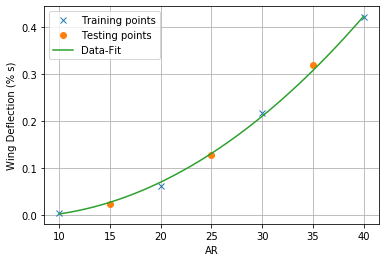

In [18]:
# Plot the points on the graph
fig3, ax = plt.subplots()

ax.plot(AR,wingDef_nonDim,'x')
ax.plot(AR_test,wingDef_nonDim_test,'o')
ax.plot(xp,yp)


ax.legend(["Training points","Testing points","Data-Fit"])
ax.grid(True)
ax.set_ylabel('Wing Deflection (% s)')
ax.set_xlabel('AR')

In [19]:
# Calculate the generalisation error for a second order 
k = 2
error = 0;
for i in range(len(AR_test)):
    btest = polynomial_basis(k,np.array([AR_test[i]]))
    ys = np.dot(btest,params)
    error += (ys-wingDef_nonDim_test[i])**2
error = error/len(AR_test)

print(error)

[[5.78979408e-05]]


## Testing error for different polynomial basis

Using a third order polynomial

In [22]:
k = 3
x = AR
b = polynomial_basis(k,x)
bpinv = np.linalg.pinv(b)
params = bpinv*wingDef_nonDim

xp = np.linspace(AR[0],AR[len(AR)-1],100)
yp3 = np.zeros([len(xp),])
for i in range(len(yp3)):
    btest = polynomial_basis(k,np.array([xp[i]]))
    yp3[i] = np.dot(btest,params)



Get the error

In [23]:
error3 = 0;
for i in range(len(AR_test)):
    btest = polynomial_basis(k,np.array([AR_test[i]]))
    ys = np.dot(btest,params)
    error3 += (ys-wingDef_nonDim_test[i])**2
error3 = error3/len(AR_test)


Using a fourth order polynomial

In [24]:
k = 4
x = AR
b = polynomial_basis(k,x)
bpinv = np.linalg.pinv(b)
params = bpinv*wingDef_nonDim

xp = np.linspace(AR[0],AR[len(AR)-1],100)
yp4 = np.zeros([len(xp),])
for i in range(len(yp4)):
    btest = polynomial_basis(k,np.array([xp[i]]))
    yp4[i] = np.dot(btest,params)



In [25]:
error4 = 0;
for i in range(len(AR_test)):
    btest = polynomial_basis(k,np.array([AR_test[i]]))
    ys = np.dot(btest,params)
    error4 += (ys-wingDef_nonDim_test[i])**2
error4 = error4/len(AR_test)

Text(0.5, 0, 'AR')

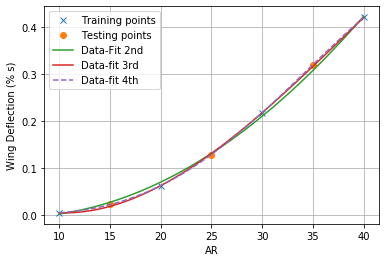

In [27]:
# Plot the points on the graph
fig4, ax = plt.subplots()

ax.plot(AR,wingDef_nonDim,'x')
ax.plot(AR_test,wingDef_nonDim_test,'o')
ax.plot(xp,yp)
ax.plot(xp,yp3)
ax.plot(xp,yp4,'--')

ax.legend(["Training points","Testing points","Data-Fit 2nd","Data-fit 3rd","Data-fit 4th"])
ax.grid(True)
ax.set_ylabel('Wing Deflection (% s)')
ax.set_xlabel('AR')

## Print errors

In [28]:
print('2nd ', error)
print('3rd ', error3)
print('4th ', error4)

2nd  [[5.78979408e-05]]
3rd  [[1.55574241e-05]]
4th  [[8.565419e-07]]
